In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [16]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    print("Device number assumed to be 0")
    device_num = 0
    num_devices = 1


img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NS.nii.gz')))

num_folds = 3

num_classes = 3

num_workers_tr = 1
batch_size_tr = 32
num_workers_vl = 1
batch_size_vl = 4

num_slices = 32
size_x = 160
size_y = 320


model_filename_base = "./results/BAMC_PTX_3DUNet-Middle-Extruded-NS.best_model.vfold.UNETR.cyclical.1e5"

num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)

Device number assumed to be 0
Num images / labels = 62 62


In [3]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

4 4 6
4 6 4
6 4 4


../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.nii.gz
../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.extruded-overlay-NS.nii.gz


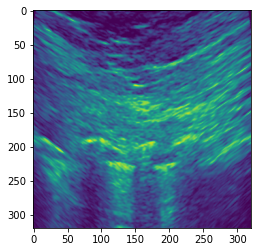

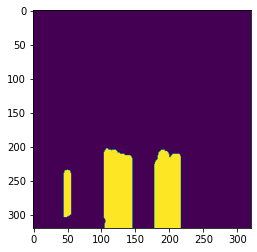

In [4]:
imgnum = 1 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['trilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            center_slice=30,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|███████████████████████████| 4/4 [00:08<00:00,  2.10s/it]


torch.Size([4, 1, 160, 320, 32])
torch.Size([160, 320, 32])
image shape: torch.Size([160, 320, 32]), label shape: torch.Size([160, 320, 32])


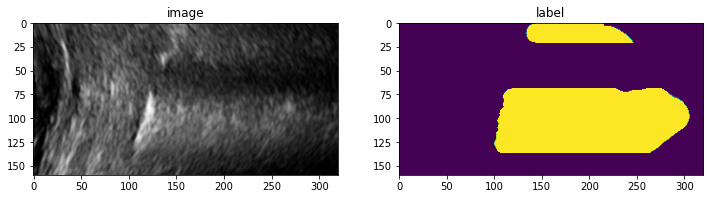

tensor(0.) tensor(2.)


In [7]:
imgnum = 2
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum][0], check_data["label"][imgnum][0])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 2])
plt.show()
print(label.min(), label.max())

In [8]:
device = torch.device("cuda:"+str(device_num))

max_epochs = 1000
net_channels=(32, 64, 128)
net_strides=(2, 2)

In [9]:
from monai.networks.nets import UNETR
# model = UNETR(1, 
#               num_classes, 
#               image.shape, 
#               feature_size=16, 
#               hidden_size=768, 
#               mlp_dim=3072, 
#               num_heads=12, 
#               pos_embed='conv', 
#               norm_name='instance', 
#               conv_block=True, 
#               res_block=True, 
#               dropout_rate=0.0, 
#               spatial_dims=3).to(device)

In [10]:
# model(check_data['image'].to(device))
# model
# check_data['image']

import gc
gc.collect()
torch.cuda.empty_cache()



In [19]:
device=0
def vfold_train(vfold_num, train_loader, val_loader):
#     model = UNet(
#         dimensions=3,
#         in_channels=1,
#         out_channels=num_classes,
#         channels=net_channels,
#         strides=net_strides,
#         num_res_units=2,
#         norm=Norm.BATCH,
#     ).to(device)
    
    model = UNETR(1, 
              num_classes, 
              image.shape, 
              feature_size=16, 
              hidden_size=768, 
              mlp_dim=3072, 
              num_heads=12, 
              pos_embed='conv', 
              norm_name='instance', 
              conv_block=True, 
              res_block=True, 
              dropout_rate=0.0, 
              spatial_dims=3).to(device)
    
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.SGD(model.parameters(), 1e-4)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-3, max_lr=1e-4, step_size_up=200)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}: lr: {scheduler.get_lr()}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        scheduler.step()
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y, num_slices)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), model_filename_base+'_'+str(vfold_num)+'.pth')
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [20]:
vfold_train(0, train_loader[i], val_loader[i])
        

----------
0: epoch 1/1000: lr: [0.001]
1/0, train_loss: 0.7529
0 epoch 1 average loss: 0.7529
----------
0: epoch 2/1000: lr: [0.0009955]
1/0, train_loss: 0.7513
0 epoch 2 average loss: 0.7513
saved new best metric model
current epoch: 2 current mean dice: 0.2751
best mean dice: 0.2751 at epoch: 2
----------
0: epoch 3/1000: lr: [0.0009910000000000001]
1/0, train_loss: 0.7505
0 epoch 3 average loss: 0.7505
----------
0: epoch 4/1000: lr: [0.0009865]
1/0, train_loss: 0.7460
0 epoch 4 average loss: 0.7460
saved new best metric model
current epoch: 4 current mean dice: 0.2885
best mean dice: 0.2885 at epoch: 4
----------
0: epoch 5/1000: lr: [0.000982]
1/0, train_loss: 0.7446
0 epoch 5 average loss: 0.7446
----------
0: epoch 6/1000: lr: [0.0009775]
1/0, train_loss: 0.7415
0 epoch 6 average loss: 0.7415
saved new best metric model
current epoch: 6 current mean dice: 0.2999
best mean dice: 0.2999 at epoch: 6
----------
0: epoch 7/1000: lr: [0.0009730000000000002]
1/0, train_loss: 0.7386
0

1/0, train_loss: 0.6816
0 epoch 51 average loss: 0.6816
----------
0: epoch 52/1000: lr: [0.0007705000000000001]
1/0, train_loss: 0.6816
0 epoch 52 average loss: 0.6816
saved new best metric model
current epoch: 52 current mean dice: 0.3549
best mean dice: 0.3549 at epoch: 52
----------
0: epoch 53/1000: lr: [0.0007660000000000002]
1/0, train_loss: 0.6824
0 epoch 53 average loss: 0.6824
----------
0: epoch 54/1000: lr: [0.0007614999999999999]
1/0, train_loss: 0.6801
0 epoch 54 average loss: 0.6801
saved new best metric model
current epoch: 54 current mean dice: 0.3551
best mean dice: 0.3551 at epoch: 54
----------
0: epoch 55/1000: lr: [0.0007570000000000001]
1/0, train_loss: 0.6803
0 epoch 55 average loss: 0.6803
----------
0: epoch 56/1000: lr: [0.0007525000000000001]
1/0, train_loss: 0.6803
0 epoch 56 average loss: 0.6803
saved new best metric model
current epoch: 56 current mean dice: 0.3552
best mean dice: 0.3552 at epoch: 56
----------
0: epoch 57/1000: lr: [0.0007479999999999998

1/0, train_loss: 0.6723
0 epoch 101 average loss: 0.6723
----------
0: epoch 102/1000: lr: [0.0005455000000000002]
1/0, train_loss: 0.6718
0 epoch 102 average loss: 0.6718
saved new best metric model
current epoch: 102 current mean dice: 0.3584
best mean dice: 0.3584 at epoch: 102
----------
0: epoch 103/1000: lr: [0.0005410000000000002]
1/0, train_loss: 0.6700
0 epoch 103 average loss: 0.6700
----------
0: epoch 104/1000: lr: [0.0005364999999999999]
1/0, train_loss: 0.6722
0 epoch 104 average loss: 0.6722
saved new best metric model
current epoch: 104 current mean dice: 0.3584
best mean dice: 0.3584 at epoch: 104
----------
0: epoch 105/1000: lr: [0.000532]
1/0, train_loss: 0.6707
0 epoch 105 average loss: 0.6707
----------
0: epoch 106/1000: lr: [0.0005275000000000002]
1/0, train_loss: 0.6727
0 epoch 106 average loss: 0.6727
saved new best metric model
current epoch: 106 current mean dice: 0.3585
best mean dice: 0.3585 at epoch: 106
----------
0: epoch 107/1000: lr: [0.00052299999999

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff65c402550>
Traceback (most recent call last):
  File "/home/local/KHQ/christopher.funk/miniconda3/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/local/KHQ/christopher.funk/miniconda3/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/local/KHQ/christopher.funk/miniconda3/envs/myenv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


1/0, train_loss: 0.6689
0 epoch 122 average loss: 0.6689


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff65c402550>
Traceback (most recent call last):
  File "/home/local/KHQ/christopher.funk/miniconda3/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/local/KHQ/christopher.funk/miniconda3/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/local/KHQ/christopher.funk/miniconda3/envs/myenv/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


saved new best metric model
current epoch: 122 current mean dice: 0.3591
best mean dice: 0.3591 at epoch: 122
----------
0: epoch 123/1000: lr: [0.0004510000000000001]
1/0, train_loss: 0.6724
0 epoch 123 average loss: 0.6724
----------
0: epoch 124/1000: lr: [0.00044649999999999985]
1/0, train_loss: 0.6692
0 epoch 124 average loss: 0.6692
saved new best metric model
current epoch: 124 current mean dice: 0.3592
best mean dice: 0.3592 at epoch: 124
----------
0: epoch 125/1000: lr: [0.0004419999999999999]
1/0, train_loss: 0.6695
0 epoch 125 average loss: 0.6695
----------
0: epoch 126/1000: lr: [0.00043750000000000006]
1/0, train_loss: 0.6686
0 epoch 126 average loss: 0.6686
saved new best metric model
current epoch: 126 current mean dice: 0.3593
best mean dice: 0.3593 at epoch: 126
----------
0: epoch 127/1000: lr: [0.0004330000000000001]
1/0, train_loss: 0.6704
0 epoch 127 average loss: 0.6704
----------
0: epoch 128/1000: lr: [0.0004285000000000003]
1/0, train_loss: 0.6751
0 epoch 128

1/0, train_loss: 0.6658
0 epoch 171 average loss: 0.6658
----------
0: epoch 172/1000: lr: [0.00023050000000000002]
1/0, train_loss: 0.6667
0 epoch 172 average loss: 0.6667
saved new best metric model
current epoch: 172 current mean dice: 0.3599
best mean dice: 0.3599 at epoch: 172
----------
0: epoch 173/1000: lr: [0.00022600000000000018]
1/0, train_loss: 0.6663
0 epoch 173 average loss: 0.6663
----------
0: epoch 174/1000: lr: [0.0002214999999999998]
1/0, train_loss: 0.6659
0 epoch 174 average loss: 0.6659
saved new best metric model
current epoch: 174 current mean dice: 0.3599
best mean dice: 0.3599 at epoch: 174
----------
0: epoch 175/1000: lr: [0.00021699999999999996]
1/0, train_loss: 0.6649
0 epoch 175 average loss: 0.6649
----------
0: epoch 176/1000: lr: [0.00021250000000000002]
1/0, train_loss: 0.6676
0 epoch 176 average loss: 0.6676
saved new best metric model
current epoch: 176 current mean dice: 0.3599
best mean dice: 0.3599 at epoch: 176
----------
0: epoch 177/1000: lr: 

current epoch: 222 current mean dice: 0.3600
best mean dice: 0.3600 at epoch: 216
----------
0: epoch 223/1000: lr: [0.00019900000000000028]
1/0, train_loss: 0.6651
0 epoch 223 average loss: 0.6651
----------
0: epoch 224/1000: lr: [0.00020350000000000023]
1/0, train_loss: 0.6648
0 epoch 224 average loss: 0.6648
current epoch: 224 current mean dice: 0.3600
best mean dice: 0.3600 at epoch: 216
----------
0: epoch 225/1000: lr: [0.00020800000000000018]
1/0, train_loss: 0.6671
0 epoch 225 average loss: 0.6671
----------
0: epoch 226/1000: lr: [0.00021250000000000002]
1/0, train_loss: 0.6680
0 epoch 226 average loss: 0.6680
current epoch: 226 current mean dice: 0.3600
best mean dice: 0.3600 at epoch: 216
----------
0: epoch 227/1000: lr: [0.00021699999999999996]
1/0, train_loss: 0.6651
0 epoch 227 average loss: 0.6651
----------
0: epoch 228/1000: lr: [0.0002214999999999998]
1/0, train_loss: 0.6656
0 epoch 228 average loss: 0.6656
saved new best metric model
current epoch: 228 current mean

1/0, train_loss: 0.6635
0 epoch 274 average loss: 0.6635
current epoch: 274 current mean dice: 0.3597
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 275/1000: lr: [0.0004330000000000001]
1/0, train_loss: 0.6622
0 epoch 275 average loss: 0.6622
----------
0: epoch 276/1000: lr: [0.00043750000000000006]
1/0, train_loss: 0.6636
0 epoch 276 average loss: 0.6636
current epoch: 276 current mean dice: 0.3596
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 277/1000: lr: [0.0004419999999999999]
1/0, train_loss: 0.6669
0 epoch 277 average loss: 0.6669
----------
0: epoch 278/1000: lr: [0.00044649999999999985]
1/0, train_loss: 0.6615
0 epoch 278 average loss: 0.6615
current epoch: 278 current mean dice: 0.3596
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 279/1000: lr: [0.0004509999999999998]
1/0, train_loss: 0.6642
0 epoch 279 average loss: 0.6642
----------
0: epoch 280/1000: lr: [0.00045550000000000007]
1/0, train_loss: 0.6658
0 epoch 280 average loss: 0.6658
curr

1/0, train_loss: 0.6595
0 epoch 328 average loss: 0.6595
current epoch: 328 current mean dice: 0.3586
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 329/1000: lr: [0.0006759999999999997]
1/0, train_loss: 0.6631
0 epoch 329 average loss: 0.6631
----------
0: epoch 330/1000: lr: [0.0006805000000000001]
1/0, train_loss: 0.6575
0 epoch 330 average loss: 0.6575
current epoch: 330 current mean dice: 0.3586
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 331/1000: lr: [0.000685]
1/0, train_loss: 0.6577
0 epoch 331 average loss: 0.6577
----------
0: epoch 332/1000: lr: [0.0006895000000000002]
1/0, train_loss: 0.6597
0 epoch 332 average loss: 0.6597
current epoch: 332 current mean dice: 0.3586
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 333/1000: lr: [0.0006940000000000002]
1/0, train_loss: 0.6593
0 epoch 333 average loss: 0.6593
----------
0: epoch 334/1000: lr: [0.0006985000000000001]
1/0, train_loss: 0.6577
0 epoch 334 average loss: 0.6577
current epoch: 334 c

1/0, train_loss: 0.6503
0 epoch 381 average loss: 0.6503
----------
0: epoch 382/1000: lr: [0.0009145000000000003]
1/0, train_loss: 0.6549
0 epoch 382 average loss: 0.6549
current epoch: 382 current mean dice: 0.3584
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 383/1000: lr: [0.0009190000000000001]
1/0, train_loss: 0.6518
0 epoch 383 average loss: 0.6518
----------
0: epoch 384/1000: lr: [0.0009235000000000001]
1/0, train_loss: 0.6489
0 epoch 384 average loss: 0.6489
current epoch: 384 current mean dice: 0.3584
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 385/1000: lr: [0.000928]
1/0, train_loss: 0.6489
0 epoch 385 average loss: 0.6489
----------
0: epoch 386/1000: lr: [0.0009324999999999998]
1/0, train_loss: 0.6483
0 epoch 386 average loss: 0.6483
current epoch: 386 current mean dice: 0.3583
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 387/1000: lr: [0.0009369999999999998]
1/0, train_loss: 0.6561
0 epoch 387 average loss: 0.6561
----------
0: epoch 

1/0, train_loss: 0.6418
0 epoch 435 average loss: 0.6418
----------
0: epoch 436/1000: lr: [0.0008425000000000001]
1/0, train_loss: 0.6414
0 epoch 436 average loss: 0.6414
current epoch: 436 current mean dice: 0.3579
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 437/1000: lr: [0.0008380000000000003]
1/0, train_loss: 0.6410
0 epoch 437 average loss: 0.6410
----------
0: epoch 438/1000: lr: [0.0008334999999999996]
1/0, train_loss: 0.6395
0 epoch 438 average loss: 0.6395
current epoch: 438 current mean dice: 0.3577
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 439/1000: lr: [0.0008290000000000005]
1/0, train_loss: 0.6422
0 epoch 439 average loss: 0.6422
----------
0: epoch 440/1000: lr: [0.0008244999999999997]
1/0, train_loss: 0.6480
0 epoch 440 average loss: 0.6480
current epoch: 440 current mean dice: 0.3575
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 441/1000: lr: [0.0008199999999999999]
1/0, train_loss: 0.6465
0 epoch 441 average loss: 0.6465
-------

current epoch: 488 current mean dice: 0.3556
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 489/1000: lr: [0.0006040000000000005]
1/0, train_loss: 0.6440
0 epoch 489 average loss: 0.6440
----------
0: epoch 490/1000: lr: [0.0005994999999999998]
1/0, train_loss: 0.6367
0 epoch 490 average loss: 0.6367
current epoch: 490 current mean dice: 0.3556
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 491/1000: lr: [0.0005949999999999998]
1/0, train_loss: 0.6378
0 epoch 491 average loss: 0.6378
----------
0: epoch 492/1000: lr: [0.0005905]
1/0, train_loss: 0.6347
0 epoch 492 average loss: 0.6347
current epoch: 492 current mean dice: 0.3555
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 493/1000: lr: [0.000586]
1/0, train_loss: 0.6406
0 epoch 493 average loss: 0.6406
----------
0: epoch 494/1000: lr: [0.0005815000000000002]
1/0, train_loss: 0.6365
0 epoch 494 average loss: 0.6365
current epoch: 494 current mean dice: 0.3554
best mean dice: 0.3601 at epoch: 246
-------

1/0, train_loss: 0.6368
0 epoch 541 average loss: 0.6368
----------
0: epoch 542/1000: lr: [0.00036549999999999994]
1/0, train_loss: 0.6359
0 epoch 542 average loss: 0.6359
current epoch: 542 current mean dice: 0.3541
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 543/1000: lr: [0.0003610000000000001]
1/0, train_loss: 0.6370
0 epoch 543 average loss: 0.6370
----------
0: epoch 544/1000: lr: [0.00035650000000000015]
1/0, train_loss: 0.6358
0 epoch 544 average loss: 0.6358
current epoch: 544 current mean dice: 0.3540
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 545/1000: lr: [0.00035199999999999945]
1/0, train_loss: 0.6416
0 epoch 545 average loss: 0.6416
----------
0: epoch 546/1000: lr: [0.00034750000000000037]
1/0, train_loss: 0.6389
0 epoch 546 average loss: 0.6389
current epoch: 546 current mean dice: 0.3540
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 547/1000: lr: [0.00034299999999999966]
1/0, train_loss: 0.6359
0 epoch 547 average loss: 0.6359
--

1/0, train_loss: 0.6386
0 epoch 594 average loss: 0.6386
current epoch: 594 current mean dice: 0.3535
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 595/1000: lr: [0.0001269999999999995]
1/0, train_loss: 0.6368
0 epoch 595 average loss: 0.6368
----------
0: epoch 596/1000: lr: [0.00012250000000000032]
1/0, train_loss: 0.6361
0 epoch 596 average loss: 0.6361
current epoch: 596 current mean dice: 0.3535
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 597/1000: lr: [0.00011799999999999962]
1/0, train_loss: 0.6312
0 epoch 597 average loss: 0.6312
----------
0: epoch 598/1000: lr: [0.00011350000000000054]
1/0, train_loss: 0.6341
0 epoch 598 average loss: 0.6341
current epoch: 598 current mean dice: 0.3535
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 599/1000: lr: [0.00010899999999999983]
1/0, train_loss: 0.6326
0 epoch 599 average loss: 0.6326
----------
0: epoch 600/1000: lr: [0.00010449999999999999]
1/0, train_loss: 0.6416
0 epoch 600 average loss: 0.6416
cu

1/0, train_loss: 0.6386
0 epoch 647 average loss: 0.6386
----------
0: epoch 648/1000: lr: [0.0003114999999999995]
1/0, train_loss: 0.6326
0 epoch 648 average loss: 0.6326
current epoch: 648 current mean dice: 0.3530
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 649/1000: lr: [0.0003160000000000002]
1/0, train_loss: 0.6338
0 epoch 649 average loss: 0.6338
----------
0: epoch 650/1000: lr: [0.00032050000000000015]
1/0, train_loss: 0.6337
0 epoch 650 average loss: 0.6337
current epoch: 650 current mean dice: 0.3530
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 651/1000: lr: [0.000325]
1/0, train_loss: 0.6353
0 epoch 651 average loss: 0.6353
----------
0: epoch 652/1000: lr: [0.00032949999999999993]
1/0, train_loss: 0.6367
0 epoch 652 average loss: 0.6367
current epoch: 652 current mean dice: 0.3530
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 653/1000: lr: [0.0003339999999999999]
1/0, train_loss: 0.6336
0 epoch 653 average loss: 0.6336
----------
0: epoc

1/0, train_loss: 0.6314
0 epoch 700 average loss: 0.6314
current epoch: 700 current mean dice: 0.3516
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 701/1000: lr: [0.00055]
1/0, train_loss: 0.6347
0 epoch 701 average loss: 0.6347
----------
0: epoch 702/1000: lr: [0.0005544999999999999]
1/0, train_loss: 0.6348
0 epoch 702 average loss: 0.6348
current epoch: 702 current mean dice: 0.3515
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 703/1000: lr: [0.0005589999999999998]
1/0, train_loss: 0.6319
0 epoch 703 average loss: 0.6319
----------
0: epoch 704/1000: lr: [0.0005635000000000005]
1/0, train_loss: 0.6387
0 epoch 704 average loss: 0.6387
current epoch: 704 current mean dice: 0.3514
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 705/1000: lr: [0.0005679999999999997]
1/0, train_loss: 0.6395
0 epoch 705 average loss: 0.6395
----------
0: epoch 706/1000: lr: [0.0005725000000000003]
1/0, train_loss: 0.6368
0 epoch 706 average loss: 0.6368
current epoch: 706 cu

1/0, train_loss: 0.6295
0 epoch 753 average loss: 0.6295
----------
0: epoch 754/1000: lr: [0.0007885000000000006]
1/0, train_loss: 0.6295
0 epoch 754 average loss: 0.6295
current epoch: 754 current mean dice: 0.3492
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 755/1000: lr: [0.0007929999999999997]
1/0, train_loss: 0.6311
0 epoch 755 average loss: 0.6311
----------
0: epoch 756/1000: lr: [0.0007975000000000004]
1/0, train_loss: 0.6342
0 epoch 756 average loss: 0.6342
current epoch: 756 current mean dice: 0.3493
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 757/1000: lr: [0.0008019999999999994]
1/0, train_loss: 0.6261
0 epoch 757 average loss: 0.6261
----------
0: epoch 758/1000: lr: [0.0008065000000000001]
1/0, train_loss: 0.6331
0 epoch 758 average loss: 0.6331
current epoch: 758 current mean dice: 0.3493
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 759/1000: lr: [0.0008110000000000001]
1/0, train_loss: 0.6291
0 epoch 759 average loss: 0.6291
-------

current epoch: 806 current mean dice: 0.3466
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 807/1000: lr: [0.0009729999999999998]
1/0, train_loss: 0.6300
0 epoch 807 average loss: 0.6300
----------
0: epoch 808/1000: lr: [0.0009684999999999999]
1/0, train_loss: 0.6258
0 epoch 808 average loss: 0.6258
current epoch: 808 current mean dice: 0.3466
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 809/1000: lr: [0.000964]
1/0, train_loss: 0.6226
0 epoch 809 average loss: 0.6226
----------
0: epoch 810/1000: lr: [0.0009595000000000001]
1/0, train_loss: 0.6316
0 epoch 810 average loss: 0.6316
current epoch: 810 current mean dice: 0.3465
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 811/1000: lr: [0.0009550000000000002]
1/0, train_loss: 0.6321
0 epoch 811 average loss: 0.6321
----------
0: epoch 812/1000: lr: [0.0009505000000000003]
1/0, train_loss: 0.6283
0 epoch 812 average loss: 0.6283
current epoch: 812 current mean dice: 0.3464
best mean dice: 0.3601 at epoch:

1/0, train_loss: 0.6237
0 epoch 859 average loss: 0.6237
----------
0: epoch 860/1000: lr: [0.0007345000000000001]
1/0, train_loss: 0.6228
0 epoch 860 average loss: 0.6228
current epoch: 860 current mean dice: 0.3429
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 861/1000: lr: [0.0007300000000000002]
1/0, train_loss: 0.6199
0 epoch 861 average loss: 0.6199
----------
0: epoch 862/1000: lr: [0.0007255000000000002]
1/0, train_loss: 0.6252
0 epoch 862 average loss: 0.6252
current epoch: 862 current mean dice: 0.3429
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 863/1000: lr: [0.0007210000000000004]
1/0, train_loss: 0.6203
0 epoch 863 average loss: 0.6203
----------
0: epoch 864/1000: lr: [0.0007164999999999997]
1/0, train_loss: 0.6232
0 epoch 864 average loss: 0.6232
current epoch: 864 current mean dice: 0.3428
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 865/1000: lr: [0.0007119999999999997]
1/0, train_loss: 0.6259
0 epoch 865 average loss: 0.6259
-------

1/0, train_loss: 0.6207
0 epoch 913 average loss: 0.6207
----------
0: epoch 914/1000: lr: [0.0004914999999999996]
1/0, train_loss: 0.6252
0 epoch 914 average loss: 0.6252
current epoch: 914 current mean dice: 0.3419
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 915/1000: lr: [0.0004869999999999998]
1/0, train_loss: 0.6208
0 epoch 915 average loss: 0.6208
----------
0: epoch 916/1000: lr: [0.00048249999999999986]
1/0, train_loss: 0.6218
0 epoch 916 average loss: 0.6218
current epoch: 916 current mean dice: 0.3419
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 917/1000: lr: [0.000478]
1/0, train_loss: 0.6225
0 epoch 917 average loss: 0.6225
----------
0: epoch 918/1000: lr: [0.00047350000000000007]
1/0, train_loss: 0.6185
0 epoch 918 average loss: 0.6185
current epoch: 918 current mean dice: 0.3417
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 919/1000: lr: [0.0004690000000000001]
1/0, train_loss: 0.6206
0 epoch 919 average loss: 0.6206
----------
0: epoc

1/0, train_loss: 0.6200
0 epoch 966 average loss: 0.6200
current epoch: 966 current mean dice: 0.3403
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 967/1000: lr: [0.00025299999999999997]
1/0, train_loss: 0.6191
0 epoch 967 average loss: 0.6191
----------
0: epoch 968/1000: lr: [0.0002485]
1/0, train_loss: 0.6176
0 epoch 968 average loss: 0.6176
current epoch: 968 current mean dice: 0.3404
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 969/1000: lr: [0.00024400000000000018]
1/0, train_loss: 0.6311
0 epoch 969 average loss: 0.6311
----------
0: epoch 970/1000: lr: [0.00023950000000000024]
1/0, train_loss: 0.6218
0 epoch 970 average loss: 0.6218
current epoch: 970 current mean dice: 0.3404
best mean dice: 0.3601 at epoch: 246
----------
0: epoch 971/1000: lr: [0.0002350000000000004]
1/0, train_loss: 0.6181
0 epoch 971 average loss: 0.6181
----------
0: epoch 972/1000: lr: [0.0002304999999999997]
1/0, train_loss: 0.6166
0 epoch 972 average loss: 0.6166
current epoch: 9

In [21]:
vfold_train(1, train_loader[i], val_loader[i])
        

----------
1: epoch 1/1000: lr: [0.001]
1/0, train_loss: 0.7805
1 epoch 1 average loss: 0.7805
----------
1: epoch 2/1000: lr: [0.0009955]
1/0, train_loss: 0.7806
1 epoch 2 average loss: 0.7806
saved new best metric model
current epoch: 2 current mean dice: 0.3181
best mean dice: 0.3181 at epoch: 2
----------
1: epoch 3/1000: lr: [0.0009910000000000001]
1/0, train_loss: 0.7794
1 epoch 3 average loss: 0.7794
----------
1: epoch 4/1000: lr: [0.0009865]
1/0, train_loss: 0.7785
1 epoch 4 average loss: 0.7785
saved new best metric model
current epoch: 4 current mean dice: 0.3204
best mean dice: 0.3204 at epoch: 4
----------
1: epoch 5/1000: lr: [0.000982]
1/0, train_loss: 0.7742
1 epoch 5 average loss: 0.7742
----------
1: epoch 6/1000: lr: [0.0009775]
1/0, train_loss: 0.7735
1 epoch 6 average loss: 0.7735
saved new best metric model
current epoch: 6 current mean dice: 0.3247
best mean dice: 0.3247 at epoch: 6
----------
1: epoch 7/1000: lr: [0.0009730000000000002]
1/0, train_loss: 0.7715
1

1/0, train_loss: 0.6985
1 epoch 53 average loss: 0.6985
----------
1: epoch 54/1000: lr: [0.0007614999999999999]
1/0, train_loss: 0.6980
1 epoch 54 average loss: 0.6980
current epoch: 54 current mean dice: 0.3492
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 55/1000: lr: [0.0007570000000000001]
1/0, train_loss: 0.6964
1 epoch 55 average loss: 0.6964
----------
1: epoch 56/1000: lr: [0.0007525000000000001]
1/0, train_loss: 0.6966
1 epoch 56 average loss: 0.6966
current epoch: 56 current mean dice: 0.3488
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 57/1000: lr: [0.0007479999999999998]
1/0, train_loss: 0.6965
1 epoch 57 average loss: 0.6965
----------
1: epoch 58/1000: lr: [0.0007434999999999999]
1/0, train_loss: 0.6942
1 epoch 58 average loss: 0.6942
current epoch: 58 current mean dice: 0.3484
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 59/1000: lr: [0.0007390000000000001]
1/0, train_loss: 0.6962
1 epoch 59 average loss: 0.6962
----------
1: epoch 60/100

1/0, train_loss: 0.6828
1 epoch 108 average loss: 0.6828
current epoch: 108 current mean dice: 0.3427
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 109/1000: lr: [0.000514]
1/0, train_loss: 0.6832
1 epoch 109 average loss: 0.6832
----------
1: epoch 110/1000: lr: [0.0005095000000000001]
1/0, train_loss: 0.6842
1 epoch 110 average loss: 0.6842
current epoch: 110 current mean dice: 0.3425
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 111/1000: lr: [0.0005050000000000002]
1/0, train_loss: 0.6827
1 epoch 111 average loss: 0.6827
----------
1: epoch 112/1000: lr: [0.0005004999999999999]
1/0, train_loss: 0.6841
1 epoch 112 average loss: 0.6841
current epoch: 112 current mean dice: 0.3423
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 113/1000: lr: [0.000496]
1/0, train_loss: 0.6821
1 epoch 113 average loss: 0.6821
----------
1: epoch 114/1000: lr: [0.0004915000000000001]
1/0, train_loss: 0.6837
1 epoch 114 average loss: 0.6837
current epoch: 114 current mean dice

1/0, train_loss: 0.6775
1 epoch 161 average loss: 0.6775
----------
1: epoch 162/1000: lr: [0.0002754999999999999]
1/0, train_loss: 0.6776
1 epoch 162 average loss: 0.6776
current epoch: 162 current mean dice: 0.3397
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 163/1000: lr: [0.000271]
1/0, train_loss: 0.6794
1 epoch 163 average loss: 0.6794
----------
1: epoch 164/1000: lr: [0.00026650000000000014]
1/0, train_loss: 0.6763
1 epoch 164 average loss: 0.6763
current epoch: 164 current mean dice: 0.3396
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 165/1000: lr: [0.0002620000000000002]
1/0, train_loss: 0.6772
1 epoch 165 average loss: 0.6772
----------
1: epoch 166/1000: lr: [0.0002574999999999999]
1/0, train_loss: 0.6772
1 epoch 166 average loss: 0.6772
current epoch: 166 current mean dice: 0.3396
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 167/1000: lr: [0.00025299999999999997]
1/0, train_loss: 0.6777
1 epoch 167 average loss: 0.6777
----------
1: epoch 1

1/0, train_loss: 0.6757
1 epoch 215 average loss: 0.6757
----------
1: epoch 216/1000: lr: [0.00016750000000000022]
1/0, train_loss: 0.6755
1 epoch 216 average loss: 0.6755
current epoch: 216 current mean dice: 0.3387
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 217/1000: lr: [0.00017200000000000006]
1/0, train_loss: 0.6768
1 epoch 217 average loss: 0.6768
----------
1: epoch 218/1000: lr: [0.0001765]
1/0, train_loss: 0.6743
1 epoch 218 average loss: 0.6743
current epoch: 218 current mean dice: 0.3387
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 219/1000: lr: [0.00018099999999999995]
1/0, train_loss: 0.6773
1 epoch 219 average loss: 0.6773
----------
1: epoch 220/1000: lr: [0.0001854999999999998]
1/0, train_loss: 0.6769
1 epoch 220 average loss: 0.6769
current epoch: 220 current mean dice: 0.3386
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 221/1000: lr: [0.00019000000000000017]
1/0, train_loss: 0.6764
1 epoch 221 average loss: 0.6764
----------
1: epoc

current epoch: 268 current mean dice: 0.3372
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 269/1000: lr: [0.0004059999999999999]
1/0, train_loss: 0.6745
1 epoch 269 average loss: 0.6745
----------
1: epoch 270/1000: lr: [0.00041049999999999984]
1/0, train_loss: 0.6744
1 epoch 270 average loss: 0.6744
current epoch: 270 current mean dice: 0.3371
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 271/1000: lr: [0.0004150000000000001]
1/0, train_loss: 0.6730
1 epoch 271 average loss: 0.6730
----------
1: epoch 272/1000: lr: [0.00041950000000000006]
1/0, train_loss: 0.6734
1 epoch 272 average loss: 0.6734
current epoch: 272 current mean dice: 0.3370
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 273/1000: lr: [0.00042400000000000033]
1/0, train_loss: 0.6725
1 epoch 273 average loss: 0.6725
----------
1: epoch 274/1000: lr: [0.0004285000000000003]
1/0, train_loss: 0.6750
1 epoch 274 average loss: 0.6750
current epoch: 274 current mean dice: 0.3370
best mean dice: 0.3

1/0, train_loss: 0.6700
1 epoch 322 average loss: 0.6700
current epoch: 322 current mean dice: 0.3355
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 323/1000: lr: [0.0006490000000000003]
1/0, train_loss: 0.6688
1 epoch 323 average loss: 0.6688
----------
1: epoch 324/1000: lr: [0.0006535000000000002]
1/0, train_loss: 0.6707
1 epoch 324 average loss: 0.6707
current epoch: 324 current mean dice: 0.3354
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 325/1000: lr: [0.0006580000000000002]
1/0, train_loss: 0.6683
1 epoch 325 average loss: 0.6683
----------
1: epoch 326/1000: lr: [0.0006625]
1/0, train_loss: 0.6666
1 epoch 326 average loss: 0.6666
current epoch: 326 current mean dice: 0.3353
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 327/1000: lr: [0.000667]
1/0, train_loss: 0.6687
1 epoch 327 average loss: 0.6687
----------
1: epoch 328/1000: lr: [0.0006714999999999998]
1/0, train_loss: 0.6676
1 epoch 328 average loss: 0.6676
current epoch: 328 current mean dic

1/0, train_loss: 0.6613
1 epoch 376 average loss: 0.6613
current epoch: 376 current mean dice: 0.3338
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 377/1000: lr: [0.0008919999999999999]
1/0, train_loss: 0.6601
1 epoch 377 average loss: 0.6601
----------
1: epoch 378/1000: lr: [0.0008964999999999998]
1/0, train_loss: 0.6625
1 epoch 378 average loss: 0.6625
current epoch: 378 current mean dice: 0.3337
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 379/1000: lr: [0.0009009999999999998]
1/0, train_loss: 0.6611
1 epoch 379 average loss: 0.6611
----------
1: epoch 380/1000: lr: [0.0009055000000000001]
1/0, train_loss: 0.6613
1 epoch 380 average loss: 0.6613
current epoch: 380 current mean dice: 0.3336
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 381/1000: lr: [0.00091]
1/0, train_loss: 0.6610
1 epoch 381 average loss: 0.6610
----------
1: epoch 382/1000: lr: [0.0009145000000000003]
1/0, train_loss: 0.6599
1 epoch 382 average loss: 0.6599
current epoch: 382 curre

1/0, train_loss: 0.6525
1 epoch 430 average loss: 0.6525
current epoch: 430 current mean dice: 0.3303
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 431/1000: lr: [0.0008649999999999997]
1/0, train_loss: 0.6538
1 epoch 431 average loss: 0.6538
----------
1: epoch 432/1000: lr: [0.0008605000000000006]
1/0, train_loss: 0.6541
1 epoch 432 average loss: 0.6541
current epoch: 432 current mean dice: 0.3302
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 433/1000: lr: [0.0008559999999999999]
1/0, train_loss: 0.6548
1 epoch 433 average loss: 0.6548
----------
1: epoch 434/1000: lr: [0.0008515]
1/0, train_loss: 0.6537
1 epoch 434 average loss: 0.6537
current epoch: 434 current mean dice: 0.3301
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 435/1000: lr: [0.0008470000000000001]
1/0, train_loss: 0.6544
1 epoch 435 average loss: 0.6544
----------
1: epoch 436/1000: lr: [0.0008425000000000001]
1/0, train_loss: 0.6531
1 epoch 436 average loss: 0.6531
current epoch: 436 cur

1/0, train_loss: 0.6502
1 epoch 483 average loss: 0.6502
----------
1: epoch 484/1000: lr: [0.0006265]
1/0, train_loss: 0.6526
1 epoch 484 average loss: 0.6526
current epoch: 484 current mean dice: 0.3301
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 485/1000: lr: [0.0006220000000000002]
1/0, train_loss: 0.6489
1 epoch 485 average loss: 0.6489
----------
1: epoch 486/1000: lr: [0.0006175000000000002]
1/0, train_loss: 0.6553
1 epoch 486 average loss: 0.6553
current epoch: 486 current mean dice: 0.3301
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 487/1000: lr: [0.0006130000000000003]
1/0, train_loss: 0.6504
1 epoch 487 average loss: 0.6504
----------
1: epoch 488/1000: lr: [0.0006084999999999996]
1/0, train_loss: 0.6511
1 epoch 488 average loss: 0.6511
current epoch: 488 current mean dice: 0.3301
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 489/1000: lr: [0.0006040000000000005]
1/0, train_loss: 0.6492
1 epoch 489 average loss: 0.6492
----------
1: epoch 49

1/0, train_loss: 0.6469
1 epoch 537 average loss: 0.6469
----------
1: epoch 538/1000: lr: [0.0003834999999999996]
1/0, train_loss: 0.6508
1 epoch 538 average loss: 0.6508
current epoch: 538 current mean dice: 0.3302
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 539/1000: lr: [0.00037900000000000054]
1/0, train_loss: 0.6487
1 epoch 539 average loss: 0.6487
----------
1: epoch 540/1000: lr: [0.00037449999999999983]
1/0, train_loss: 0.6467
1 epoch 540 average loss: 0.6467
current epoch: 540 current mean dice: 0.3302
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 541/1000: lr: [0.0003699999999999999]
1/0, train_loss: 0.6491
1 epoch 541 average loss: 0.6491
----------
1: epoch 542/1000: lr: [0.00036549999999999994]
1/0, train_loss: 0.6489
1 epoch 542 average loss: 0.6489
current epoch: 542 current mean dice: 0.3302
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 543/1000: lr: [0.0003610000000000001]
1/0, train_loss: 0.6479
1 epoch 543 average loss: 0.6479
-------

current epoch: 590 current mean dice: 0.3303
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 591/1000: lr: [0.00014499999999999984]
1/0, train_loss: 0.6477
1 epoch 591 average loss: 0.6477
----------
1: epoch 592/1000: lr: [0.0001405]
1/0, train_loss: 0.6461
1 epoch 592 average loss: 0.6461
current epoch: 592 current mean dice: 0.3303
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 593/1000: lr: [0.00013600000000000005]
1/0, train_loss: 0.6509
1 epoch 593 average loss: 0.6509
----------
1: epoch 594/1000: lr: [0.00013150000000000021]
1/0, train_loss: 0.6468
1 epoch 594 average loss: 0.6468
current epoch: 594 current mean dice: 0.3303
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 595/1000: lr: [0.0001269999999999995]
1/0, train_loss: 0.6468
1 epoch 595 average loss: 0.6468
----------
1: epoch 596/1000: lr: [0.00012250000000000032]
1/0, train_loss: 0.6470
1 epoch 596 average loss: 0.6470
current epoch: 596 current mean dice: 0.3303
best mean dice: 0.3601 at epoc

1/0, train_loss: 0.6477
1 epoch 643 average loss: 0.6477
----------
1: epoch 644/1000: lr: [0.0002934999999999999]
1/0, train_loss: 0.6473
1 epoch 644 average loss: 0.6473
current epoch: 644 current mean dice: 0.3303
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 645/1000: lr: [0.00029800000000000063]
1/0, train_loss: 0.6449
1 epoch 645 average loss: 0.6449
----------
1: epoch 646/1000: lr: [0.0003024999999999997]
1/0, train_loss: 0.6475
1 epoch 646 average loss: 0.6475
current epoch: 646 current mean dice: 0.3304
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 647/1000: lr: [0.0003070000000000004]
1/0, train_loss: 0.6480
1 epoch 647 average loss: 0.6480
----------
1: epoch 648/1000: lr: [0.0003114999999999995]
1/0, train_loss: 0.6472
1 epoch 648 average loss: 0.6472
current epoch: 648 current mean dice: 0.3304
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 649/1000: lr: [0.0003160000000000002]
1/0, train_loss: 0.6478
1 epoch 649 average loss: 0.6478
---------

current epoch: 696 current mean dice: 0.3304
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 697/1000: lr: [0.0005320000000000004]
1/0, train_loss: 0.6442
1 epoch 697 average loss: 0.6442
----------
1: epoch 698/1000: lr: [0.0005364999999999995]
1/0, train_loss: 0.6434
1 epoch 698 average loss: 0.6434
current epoch: 698 current mean dice: 0.3304
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 699/1000: lr: [0.0005410000000000002]
1/0, train_loss: 0.6453
1 epoch 699 average loss: 0.6453
----------
1: epoch 700/1000: lr: [0.0005455000000000002]
1/0, train_loss: 0.6433
1 epoch 700 average loss: 0.6433
current epoch: 700 current mean dice: 0.3305
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 701/1000: lr: [0.00055]
1/0, train_loss: 0.6455
1 epoch 701 average loss: 0.6455
----------
1: epoch 702/1000: lr: [0.0005544999999999999]
1/0, train_loss: 0.6441
1 epoch 702 average loss: 0.6441
current epoch: 702 current mean dice: 0.3305
best mean dice: 0.3601 at epoch: 30


1/0, train_loss: 0.6484
1 epoch 750 average loss: 0.6484
current epoch: 750 current mean dice: 0.3310
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 751/1000: lr: [0.0007750000000000001]
1/0, train_loss: 0.6480
1 epoch 751 average loss: 0.6480
----------
1: epoch 752/1000: lr: [0.0007794999999999999]
1/0, train_loss: 0.6447
1 epoch 752 average loss: 0.6447
current epoch: 752 current mean dice: 0.3310
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 753/1000: lr: [0.0007839999999999999]
1/0, train_loss: 0.6421
1 epoch 753 average loss: 0.6421
----------
1: epoch 754/1000: lr: [0.0007885000000000006]
1/0, train_loss: 0.6473
1 epoch 754 average loss: 0.6473
current epoch: 754 current mean dice: 0.3310
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 755/1000: lr: [0.0007929999999999997]
1/0, train_loss: 0.6465
1 epoch 755 average loss: 0.6465
----------
1: epoch 756/1000: lr: [0.0007975000000000004]
1/0, train_loss: 0.6446
1 epoch 756 average loss: 0.6446
current ep

1/0, train_loss: 0.6405
1 epoch 804 average loss: 0.6405
current epoch: 804 current mean dice: 0.3317
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 805/1000: lr: [0.0009820000000000005]
1/0, train_loss: 0.6387
1 epoch 805 average loss: 0.6387
----------
1: epoch 806/1000: lr: [0.0009774999999999996]
1/0, train_loss: 0.6402
1 epoch 806 average loss: 0.6402
current epoch: 806 current mean dice: 0.3317
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 807/1000: lr: [0.0009729999999999998]
1/0, train_loss: 0.6417
1 epoch 807 average loss: 0.6417
----------
1: epoch 808/1000: lr: [0.0009684999999999999]
1/0, train_loss: 0.6375
1 epoch 808 average loss: 0.6375
current epoch: 808 current mean dice: 0.3317
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 809/1000: lr: [0.000964]
1/0, train_loss: 0.6442
1 epoch 809 average loss: 0.6442
----------
1: epoch 810/1000: lr: [0.0009595000000000001]
1/0, train_loss: 0.6408
1 epoch 810 average loss: 0.6408
current epoch: 810 curr

1/0, train_loss: 0.6352
1 epoch 857 average loss: 0.6352
----------
1: epoch 858/1000: lr: [0.0007434999999999999]
1/0, train_loss: 0.6363
1 epoch 858 average loss: 0.6363
current epoch: 858 current mean dice: 0.3324
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 859/1000: lr: [0.0007390000000000001]
1/0, train_loss: 0.6338
1 epoch 859 average loss: 0.6338
----------
1: epoch 860/1000: lr: [0.0007345000000000001]
1/0, train_loss: 0.6351
1 epoch 860 average loss: 0.6351
current epoch: 860 current mean dice: 0.3324
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 861/1000: lr: [0.0007300000000000002]
1/0, train_loss: 0.6427
1 epoch 861 average loss: 0.6427
----------
1: epoch 862/1000: lr: [0.0007255000000000002]
1/0, train_loss: 0.6408
1 epoch 862 average loss: 0.6408
current epoch: 862 current mean dice: 0.3324
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 863/1000: lr: [0.0007210000000000004]
1/0, train_loss: 0.6347
1 epoch 863 average loss: 0.6347
----------

1/0, train_loss: 0.6403
1 epoch 911 average loss: 0.6403
----------
1: epoch 912/1000: lr: [0.0005005000000000003]
1/0, train_loss: 0.6348
1 epoch 912 average loss: 0.6348
current epoch: 912 current mean dice: 0.3327
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 913/1000: lr: [0.0004960000000000003]
1/0, train_loss: 0.6338
1 epoch 913 average loss: 0.6338
----------
1: epoch 914/1000: lr: [0.0004914999999999996]
1/0, train_loss: 0.6382
1 epoch 914 average loss: 0.6382
current epoch: 914 current mean dice: 0.3327
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 915/1000: lr: [0.0004869999999999998]
1/0, train_loss: 0.6318
1 epoch 915 average loss: 0.6318
----------
1: epoch 916/1000: lr: [0.00048249999999999986]
1/0, train_loss: 0.6352
1 epoch 916 average loss: 0.6352
current epoch: 916 current mean dice: 0.3327
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 917/1000: lr: [0.000478]
1/0, train_loss: 0.6355
1 epoch 917 average loss: 0.6355
----------
1: epoch 91

current epoch: 964 current mean dice: 0.3327
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 965/1000: lr: [0.00026199999999999975]
1/0, train_loss: 0.6308
1 epoch 965 average loss: 0.6308
----------
1: epoch 966/1000: lr: [0.0002574999999999999]
1/0, train_loss: 0.6421
1 epoch 966 average loss: 0.6421
current epoch: 966 current mean dice: 0.3327
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 967/1000: lr: [0.00025299999999999997]
1/0, train_loss: 0.6390
1 epoch 967 average loss: 0.6390
----------
1: epoch 968/1000: lr: [0.0002485]
1/0, train_loss: 0.6334
1 epoch 968 average loss: 0.6334
current epoch: 968 current mean dice: 0.3327
best mean dice: 0.3601 at epoch: 30
----------
1: epoch 969/1000: lr: [0.00024400000000000018]
1/0, train_loss: 0.6386
1 epoch 969 average loss: 0.6386
----------
1: epoch 970/1000: lr: [0.00023950000000000024]
1/0, train_loss: 0.6361
1 epoch 970 average loss: 0.6361
current epoch: 970 current mean dice: 0.3327
best mean dice: 0.3601 at epoc

In [22]:
vfold_train(2, train_loader[i], val_loader[i])
        

----------
2: epoch 1/1000: lr: [0.001]
1/0, train_loss: 0.7899
2 epoch 1 average loss: 0.7899
----------
2: epoch 2/1000: lr: [0.0009955]
1/0, train_loss: 0.7895
2 epoch 2 average loss: 0.7895
saved new best metric model
current epoch: 2 current mean dice: 0.3264
best mean dice: 0.3264 at epoch: 2
----------
2: epoch 3/1000: lr: [0.0009910000000000001]
1/0, train_loss: 0.7881
2 epoch 3 average loss: 0.7881
----------
2: epoch 4/1000: lr: [0.0009865]
1/0, train_loss: 0.7842
2 epoch 4 average loss: 0.7842
saved new best metric model
current epoch: 4 current mean dice: 0.3312
best mean dice: 0.3312 at epoch: 4
----------
2: epoch 5/1000: lr: [0.000982]
1/0, train_loss: 0.7825
2 epoch 5 average loss: 0.7825
----------
2: epoch 6/1000: lr: [0.0009775]
1/0, train_loss: 0.7764
2 epoch 6 average loss: 0.7764
saved new best metric model
current epoch: 6 current mean dice: 0.3414
best mean dice: 0.3414 at epoch: 6
----------
2: epoch 7/1000: lr: [0.0009730000000000002]
1/0, train_loss: 0.7719
2

1/0, train_loss: 0.7041
2 epoch 55 average loss: 0.7041
----------
2: epoch 56/1000: lr: [0.0007525000000000001]
1/0, train_loss: 0.7025
2 epoch 56 average loss: 0.7025
current epoch: 56 current mean dice: 0.3287
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 57/1000: lr: [0.0007479999999999998]
1/0, train_loss: 0.7027
2 epoch 57 average loss: 0.7027
----------
2: epoch 58/1000: lr: [0.0007434999999999999]
1/0, train_loss: 0.7028
2 epoch 58 average loss: 0.7028
current epoch: 58 current mean dice: 0.3288
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 59/1000: lr: [0.0007390000000000001]
1/0, train_loss: 0.7031
2 epoch 59 average loss: 0.7031
----------
2: epoch 60/1000: lr: [0.0007345000000000001]
1/0, train_loss: 0.7031
2 epoch 60 average loss: 0.7031
current epoch: 60 current mean dice: 0.3289
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 61/1000: lr: [0.0007300000000000002]
1/0, train_loss: 0.7023
2 epoch 61 average loss: 0.7023
----------
2: epoch 62/100

1/0, train_loss: 0.6894
2 epoch 110 average loss: 0.6894
current epoch: 110 current mean dice: 0.3304
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 111/1000: lr: [0.0005050000000000002]
1/0, train_loss: 0.6885
2 epoch 111 average loss: 0.6885
----------
2: epoch 112/1000: lr: [0.0005004999999999999]
1/0, train_loss: 0.6903
2 epoch 112 average loss: 0.6903
current epoch: 112 current mean dice: 0.3304
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 113/1000: lr: [0.000496]
1/0, train_loss: 0.6886
2 epoch 113 average loss: 0.6886
----------
2: epoch 114/1000: lr: [0.0004915000000000001]
1/0, train_loss: 0.6880
2 epoch 114 average loss: 0.6880
current epoch: 114 current mean dice: 0.3303
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 115/1000: lr: [0.00048700000000000013]
1/0, train_loss: 0.6883
2 epoch 115 average loss: 0.6883
----------
2: epoch 116/1000: lr: [0.00048249999999999986]
1/0, train_loss: 0.6870
2 epoch 116 average loss: 0.6870
current epoch: 116 cu

1/0, train_loss: 0.6825
2 epoch 163 average loss: 0.6825
----------
2: epoch 164/1000: lr: [0.00026650000000000014]
1/0, train_loss: 0.6838
2 epoch 164 average loss: 0.6838
current epoch: 164 current mean dice: 0.3292
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 165/1000: lr: [0.0002620000000000002]
1/0, train_loss: 0.6828
2 epoch 165 average loss: 0.6828
----------
2: epoch 166/1000: lr: [0.0002574999999999999]
1/0, train_loss: 0.6846
2 epoch 166 average loss: 0.6846
current epoch: 166 current mean dice: 0.3292
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 167/1000: lr: [0.00025299999999999997]
1/0, train_loss: 0.6834
2 epoch 167 average loss: 0.6834
----------
2: epoch 168/1000: lr: [0.0002485]
1/0, train_loss: 0.6830
2 epoch 168 average loss: 0.6830
current epoch: 168 current mean dice: 0.3292
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 169/1000: lr: [0.00024400000000000018]
1/0, train_loss: 0.6821
2 epoch 169 average loss: 0.6821
----------
2: epoch

1/0, train_loss: 0.6822
2 epoch 217 average loss: 0.6822
----------
2: epoch 218/1000: lr: [0.0001765]
1/0, train_loss: 0.6808
2 epoch 218 average loss: 0.6808
current epoch: 218 current mean dice: 0.3286
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 219/1000: lr: [0.00018099999999999995]
1/0, train_loss: 0.6835
2 epoch 219 average loss: 0.6835
----------
2: epoch 220/1000: lr: [0.0001854999999999998]
1/0, train_loss: 0.6816
2 epoch 220 average loss: 0.6816
current epoch: 220 current mean dice: 0.3286
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 221/1000: lr: [0.00019000000000000017]
1/0, train_loss: 0.6818
2 epoch 221 average loss: 0.6818
----------
2: epoch 222/1000: lr: [0.0001945]
1/0, train_loss: 0.6827
2 epoch 222 average loss: 0.6827
current epoch: 222 current mean dice: 0.3286
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 223/1000: lr: [0.00019900000000000028]
1/0, train_loss: 0.6823
2 epoch 223 average loss: 0.6823
----------
2: epoch 224/1000: l

current epoch: 270 current mean dice: 0.3276
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 271/1000: lr: [0.0004150000000000001]
1/0, train_loss: 0.6788
2 epoch 271 average loss: 0.6788
----------
2: epoch 272/1000: lr: [0.00041950000000000006]
1/0, train_loss: 0.6790
2 epoch 272 average loss: 0.6790
current epoch: 272 current mean dice: 0.3276
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 273/1000: lr: [0.00042400000000000033]
1/0, train_loss: 0.6773
2 epoch 273 average loss: 0.6773
----------
2: epoch 274/1000: lr: [0.0004285000000000003]
1/0, train_loss: 0.6778
2 epoch 274 average loss: 0.6778
current epoch: 274 current mean dice: 0.3276
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 275/1000: lr: [0.0004330000000000001]
1/0, train_loss: 0.6777
2 epoch 275 average loss: 0.6777
----------
2: epoch 276/1000: lr: [0.00043750000000000006]
1/0, train_loss: 0.6791
2 epoch 276 average loss: 0.6791
current epoch: 276 current mean dice: 0.3275
best mean dice: 0.3

1/0, train_loss: 0.6744
2 epoch 324 average loss: 0.6744
current epoch: 324 current mean dice: 0.3263
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 325/1000: lr: [0.0006580000000000002]
1/0, train_loss: 0.6747
2 epoch 325 average loss: 0.6747
----------
2: epoch 326/1000: lr: [0.0006625]
1/0, train_loss: 0.6731
2 epoch 326 average loss: 0.6731
current epoch: 326 current mean dice: 0.3262
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 327/1000: lr: [0.000667]
1/0, train_loss: 0.6722
2 epoch 327 average loss: 0.6722
----------
2: epoch 328/1000: lr: [0.0006714999999999998]
1/0, train_loss: 0.6737
2 epoch 328 average loss: 0.6737
current epoch: 328 current mean dice: 0.3262
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 329/1000: lr: [0.0006759999999999997]
1/0, train_loss: 0.6727
2 epoch 329 average loss: 0.6727
----------
2: epoch 330/1000: lr: [0.0006805000000000001]
1/0, train_loss: 0.6717
2 epoch 330 average loss: 0.6717
current epoch: 330 current mean dic

1/0, train_loss: 0.6657
2 epoch 378 average loss: 0.6657
current epoch: 378 current mean dice: 0.3253
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 379/1000: lr: [0.0009009999999999998]
1/0, train_loss: 0.6640
2 epoch 379 average loss: 0.6640
----------
2: epoch 380/1000: lr: [0.0009055000000000001]
1/0, train_loss: 0.6661
2 epoch 380 average loss: 0.6661
current epoch: 380 current mean dice: 0.3253
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 381/1000: lr: [0.00091]
1/0, train_loss: 0.6656
2 epoch 381 average loss: 0.6656
----------
2: epoch 382/1000: lr: [0.0009145000000000003]
1/0, train_loss: 0.6645
2 epoch 382 average loss: 0.6645
current epoch: 382 current mean dice: 0.3253
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 383/1000: lr: [0.0009190000000000001]
1/0, train_loss: 0.6666
2 epoch 383 average loss: 0.6666
----------
2: epoch 384/1000: lr: [0.0009235000000000001]
1/0, train_loss: 0.6678
2 epoch 384 average loss: 0.6678
current epoch: 384 curre

1/0, train_loss: 0.6562
2 epoch 432 average loss: 0.6562
current epoch: 432 current mean dice: 0.3255
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 433/1000: lr: [0.0008559999999999999]
1/0, train_loss: 0.6576
2 epoch 433 average loss: 0.6576
----------
2: epoch 434/1000: lr: [0.0008515]
1/0, train_loss: 0.6562
2 epoch 434 average loss: 0.6562
current epoch: 434 current mean dice: 0.3256
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 435/1000: lr: [0.0008470000000000001]
1/0, train_loss: 0.6604
2 epoch 435 average loss: 0.6604
----------
2: epoch 436/1000: lr: [0.0008425000000000001]
1/0, train_loss: 0.6616
2 epoch 436 average loss: 0.6616
current epoch: 436 current mean dice: 0.3255
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 437/1000: lr: [0.0008380000000000003]
1/0, train_loss: 0.6568
2 epoch 437 average loss: 0.6568
----------
2: epoch 438/1000: lr: [0.0008334999999999996]
1/0, train_loss: 0.6565
2 epoch 438 average loss: 0.6565
current epoch: 438 cur

1/0, train_loss: 0.6541
2 epoch 485 average loss: 0.6541
----------
2: epoch 486/1000: lr: [0.0006175000000000002]
1/0, train_loss: 0.6571
2 epoch 486 average loss: 0.6571
current epoch: 486 current mean dice: 0.3261
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 487/1000: lr: [0.0006130000000000003]
1/0, train_loss: 0.6530
2 epoch 487 average loss: 0.6530
----------
2: epoch 488/1000: lr: [0.0006084999999999996]
1/0, train_loss: 0.6550
2 epoch 488 average loss: 0.6550
current epoch: 488 current mean dice: 0.3262
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 489/1000: lr: [0.0006040000000000005]
1/0, train_loss: 0.6525
2 epoch 489 average loss: 0.6525
----------
2: epoch 490/1000: lr: [0.0005994999999999998]
1/0, train_loss: 0.6537
2 epoch 490 average loss: 0.6537
current epoch: 490 current mean dice: 0.3262
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 491/1000: lr: [0.0005949999999999998]
1/0, train_loss: 0.6515
2 epoch 491 average loss: 0.6515
----------

current epoch: 538 current mean dice: 0.3265
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 539/1000: lr: [0.00037900000000000054]
1/0, train_loss: 0.6547
2 epoch 539 average loss: 0.6547
----------
2: epoch 540/1000: lr: [0.00037449999999999983]
1/0, train_loss: 0.6530
2 epoch 540 average loss: 0.6530
current epoch: 540 current mean dice: 0.3265
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 541/1000: lr: [0.0003699999999999999]
1/0, train_loss: 0.6516
2 epoch 541 average loss: 0.6516
----------
2: epoch 542/1000: lr: [0.00036549999999999994]
1/0, train_loss: 0.6517
2 epoch 542 average loss: 0.6517
current epoch: 542 current mean dice: 0.3266
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 543/1000: lr: [0.0003610000000000001]
1/0, train_loss: 0.6517
2 epoch 543 average loss: 0.6517
----------
2: epoch 544/1000: lr: [0.00035650000000000015]
1/0, train_loss: 0.6551
2 epoch 544 average loss: 0.6551
current epoch: 544 current mean dice: 0.3266
best mean dice: 0.

1/0, train_loss: 0.6519
2 epoch 591 average loss: 0.6519
----------
2: epoch 592/1000: lr: [0.0001405]
1/0, train_loss: 0.6513
2 epoch 592 average loss: 0.6513
current epoch: 592 current mean dice: 0.3269
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 593/1000: lr: [0.00013600000000000005]
1/0, train_loss: 0.6496
2 epoch 593 average loss: 0.6496
----------
2: epoch 594/1000: lr: [0.00013150000000000021]
1/0, train_loss: 0.6503
2 epoch 594 average loss: 0.6503
current epoch: 594 current mean dice: 0.3269
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 595/1000: lr: [0.0001269999999999995]
1/0, train_loss: 0.6500
2 epoch 595 average loss: 0.6500
----------
2: epoch 596/1000: lr: [0.00012250000000000032]
1/0, train_loss: 0.6538
2 epoch 596 average loss: 0.6538
current epoch: 596 current mean dice: 0.3269
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 597/1000: lr: [0.00011799999999999962]
1/0, train_loss: 0.6525
2 epoch 597 average loss: 0.6525
----------
2: epoc

current epoch: 644 current mean dice: 0.3270
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 645/1000: lr: [0.00029800000000000063]
1/0, train_loss: 0.6544
2 epoch 645 average loss: 0.6544
----------
2: epoch 646/1000: lr: [0.0003024999999999997]
1/0, train_loss: 0.6484
2 epoch 646 average loss: 0.6484
current epoch: 646 current mean dice: 0.3271
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 647/1000: lr: [0.0003070000000000004]
1/0, train_loss: 0.6520
2 epoch 647 average loss: 0.6520
----------
2: epoch 648/1000: lr: [0.0003114999999999995]
1/0, train_loss: 0.6509
2 epoch 648 average loss: 0.6509
current epoch: 648 current mean dice: 0.3271
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 649/1000: lr: [0.0003160000000000002]
1/0, train_loss: 0.6481
2 epoch 649 average loss: 0.6481
----------
2: epoch 650/1000: lr: [0.00032050000000000015]
1/0, train_loss: 0.6489
2 epoch 650 average loss: 0.6489
current epoch: 650 current mean dice: 0.3271
best mean dice: 0.35

1/0, train_loss: 0.6484
2 epoch 697 average loss: 0.6484
----------
2: epoch 698/1000: lr: [0.0005364999999999995]
1/0, train_loss: 0.6495
2 epoch 698 average loss: 0.6495
current epoch: 698 current mean dice: 0.3273
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 699/1000: lr: [0.0005410000000000002]
1/0, train_loss: 0.6470
2 epoch 699 average loss: 0.6470
----------
2: epoch 700/1000: lr: [0.0005455000000000002]
1/0, train_loss: 0.6486
2 epoch 700 average loss: 0.6486
current epoch: 700 current mean dice: 0.3274
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 701/1000: lr: [0.00055]
1/0, train_loss: 0.6475
2 epoch 701 average loss: 0.6475
----------
2: epoch 702/1000: lr: [0.0005544999999999999]
1/0, train_loss: 0.6487
2 epoch 702 average loss: 0.6487
current epoch: 702 current mean dice: 0.3274
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 703/1000: lr: [0.0005589999999999998]
1/0, train_loss: 0.6534
2 epoch 703 average loss: 0.6534
----------
2: epoch 704/

1/0, train_loss: 0.6502
2 epoch 751 average loss: 0.6502
----------
2: epoch 752/1000: lr: [0.0007794999999999999]
1/0, train_loss: 0.6442
2 epoch 752 average loss: 0.6442
current epoch: 752 current mean dice: 0.3282
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 753/1000: lr: [0.0007839999999999999]
1/0, train_loss: 0.6471
2 epoch 753 average loss: 0.6471
----------
2: epoch 754/1000: lr: [0.0007885000000000006]
1/0, train_loss: 0.6466
2 epoch 754 average loss: 0.6466
current epoch: 754 current mean dice: 0.3282
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 755/1000: lr: [0.0007929999999999997]
1/0, train_loss: 0.6530
2 epoch 755 average loss: 0.6530
----------
2: epoch 756/1000: lr: [0.0007975000000000004]
1/0, train_loss: 0.6489
2 epoch 756 average loss: 0.6489
current epoch: 756 current mean dice: 0.3283
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 757/1000: lr: [0.0008019999999999994]
1/0, train_loss: 0.6454
2 epoch 757 average loss: 0.6454
----------

1/0, train_loss: 0.6418
2 epoch 805 average loss: 0.6418
----------
2: epoch 806/1000: lr: [0.0009774999999999996]
1/0, train_loss: 0.6431
2 epoch 806 average loss: 0.6431
current epoch: 806 current mean dice: 0.3286
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 807/1000: lr: [0.0009729999999999998]
1/0, train_loss: 0.6477
2 epoch 807 average loss: 0.6477
----------
2: epoch 808/1000: lr: [0.0009684999999999999]
1/0, train_loss: 0.6440
2 epoch 808 average loss: 0.6440
current epoch: 808 current mean dice: 0.3286
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 809/1000: lr: [0.000964]
1/0, train_loss: 0.6432
2 epoch 809 average loss: 0.6432
----------
2: epoch 810/1000: lr: [0.0009595000000000001]
1/0, train_loss: 0.6415
2 epoch 810 average loss: 0.6415
current epoch: 810 current mean dice: 0.3286
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 811/1000: lr: [0.0009550000000000002]
1/0, train_loss: 0.6412
2 epoch 811 average loss: 0.6412
----------
2: epoch 812

current epoch: 858 current mean dice: 0.3298
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 859/1000: lr: [0.0007390000000000001]
1/0, train_loss: 0.6395
2 epoch 859 average loss: 0.6395
----------
2: epoch 860/1000: lr: [0.0007345000000000001]
1/0, train_loss: 0.6441
2 epoch 860 average loss: 0.6441
current epoch: 860 current mean dice: 0.3298
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 861/1000: lr: [0.0007300000000000002]
1/0, train_loss: 0.6387
2 epoch 861 average loss: 0.6387
----------
2: epoch 862/1000: lr: [0.0007255000000000002]
1/0, train_loss: 0.6409
2 epoch 862 average loss: 0.6409
current epoch: 862 current mean dice: 0.3299
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 863/1000: lr: [0.0007210000000000004]
1/0, train_loss: 0.6430
2 epoch 863 average loss: 0.6430
----------
2: epoch 864/1000: lr: [0.0007164999999999997]
1/0, train_loss: 0.6422
2 epoch 864 average loss: 0.6422
current epoch: 864 current mean dice: 0.3299
best mean dice: 0.3590

1/0, train_loss: 0.6433
2 epoch 912 average loss: 0.6433
current epoch: 912 current mean dice: 0.3306
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 913/1000: lr: [0.0004960000000000003]
1/0, train_loss: 0.6373
2 epoch 913 average loss: 0.6373
----------
2: epoch 914/1000: lr: [0.0004914999999999996]
1/0, train_loss: 0.6410
2 epoch 914 average loss: 0.6410
current epoch: 914 current mean dice: 0.3306
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 915/1000: lr: [0.0004869999999999998]
1/0, train_loss: 0.6387
2 epoch 915 average loss: 0.6387
----------
2: epoch 916/1000: lr: [0.00048249999999999986]
1/0, train_loss: 0.6436
2 epoch 916 average loss: 0.6436
current epoch: 916 current mean dice: 0.3306
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 917/1000: lr: [0.000478]
1/0, train_loss: 0.6354
2 epoch 917 average loss: 0.6354
----------
2: epoch 918/1000: lr: [0.00047350000000000007]
1/0, train_loss: 0.6430
2 epoch 918 average loss: 0.6430
current epoch: 918 cu

1/0, train_loss: 0.6386
2 epoch 965 average loss: 0.6386
----------
2: epoch 966/1000: lr: [0.0002574999999999999]
1/0, train_loss: 0.6372
2 epoch 966 average loss: 0.6372
current epoch: 966 current mean dice: 0.3310
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 967/1000: lr: [0.00025299999999999997]
1/0, train_loss: 0.6361
2 epoch 967 average loss: 0.6361
----------
2: epoch 968/1000: lr: [0.0002485]
1/0, train_loss: 0.6405
2 epoch 968 average loss: 0.6405
current epoch: 968 current mean dice: 0.3311
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 969/1000: lr: [0.00024400000000000018]
1/0, train_loss: 0.6474
2 epoch 969 average loss: 0.6474
----------
2: epoch 970/1000: lr: [0.00023950000000000024]
1/0, train_loss: 0.6398
2 epoch 970 average loss: 0.6398
current epoch: 970 current mean dice: 0.3311
best mean dice: 0.3590 at epoch: 12
----------
2: epoch 971/1000: lr: [0.0002350000000000004]
1/0, train_loss: 0.6350
2 epoch 971 average loss: 0.6350
----------
2: epoch

In [ ]:
!mkdir results